In [1]:
# File System
import os, sys, pickle as pkl
from os import path as pth
import itertools as it

# Plotting
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker

# Math
import numpy as np
from numpy import linalg as la
import pandas as pd
pd.options.mode.chained_assignment = None

from scipy.stats import norm, uniform, multivariate_normal
import scipy.optimize as opt
from functools import reduce, partial

# Display
from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from prbmset_1_funcs import *

from Model import TwoSignal

### Problem 1

##### From Problem Set 1 Question 1

In [2]:
### Load Data
data_path = pth.join("data")
data = pd.read_csv(pth.join(data_path, 'first_3_data.csv'),index_col="ID")

In [3]:
def ellipse_points(A, c, n_conf=1):
    eigval1, eigvec1 = la.eig(errors(A, c))

    θs  = np.linspace(0,2*np.pi, num=1_000)
    return (1/(np.sqrt(eigval1[None,:]/ n_conf)) * eigvec1) @ [np.sin(θs), np.cos(θs)]
    

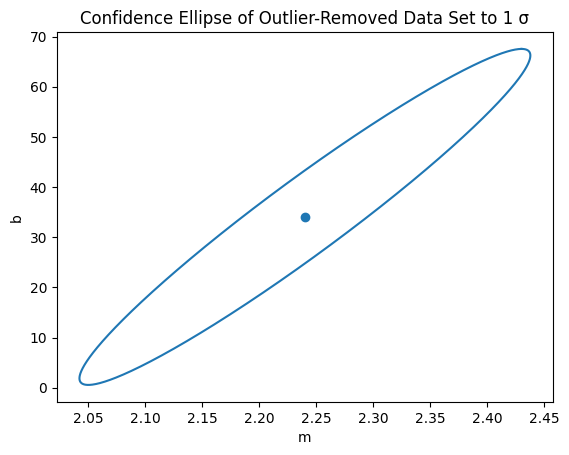

In [4]:
A_1, y_1, c_1 = generate_mats(data[4:20],'x')
x_1 = calc_params(A_1, y_1, c_1)

epoints1 = ellipse_points(A_1, c_1, 1)

_= plt.plot(epoints1[0] + x_1[1], epoints1[1] + x_1[0])
_= plt.scatter(x_1[1], x_1[0])

_= plt.title("Confidence Ellipse of Outlier-Removed Data Set to 1 σ")
_= plt.xlabel("m")
_= plt.ylabel("b")

##### From Problem Set 1 Question 2

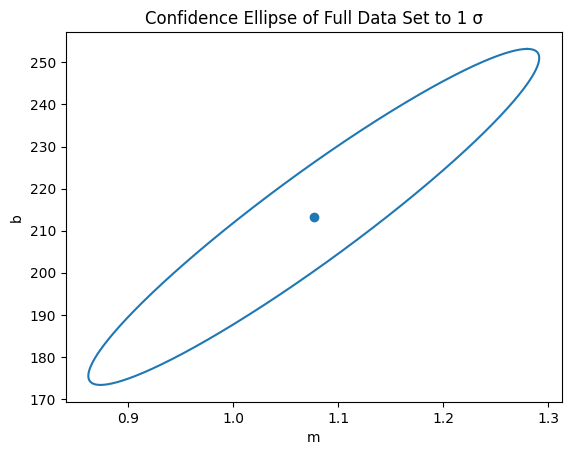

In [5]:
A_2, y_2, c_2 = generate_mats(data,'x')
x_2 = calc_params(A_2, y_2, c_2)

epoints2 = ellipse_points(A_2, c_2, 1)

_= plt.plot(epoints2[0] + x_2[1], epoints2[1] + x_2[0])
_= plt.scatter(x_2[1], x_2[0])

_= plt.title("Confidence Ellipse of Full Data Set to 1 σ")
_= plt.xlabel("m")
_= plt.ylabel("b")

##### Comparing Data Sets

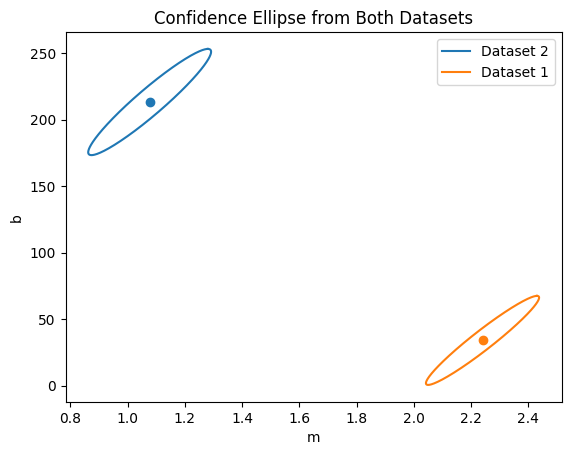

In [6]:
_= plt.plot(epoints2[0] + x_2[1], epoints2[1] + x_2[0], label="Dataset 2")
_= plt.scatter(x_2[1], x_2[0])
_= plt.plot(epoints1[0] + x_1[1], epoints1[1] + x_1[0], label="Dataset 1")
_= plt.scatter(x_1[1], x_1[0])
_= plt.legend()

_= plt.title("Confidence Ellipse from Both Datasets")
_= plt.xlabel("m")
_= plt.ylabel("b")

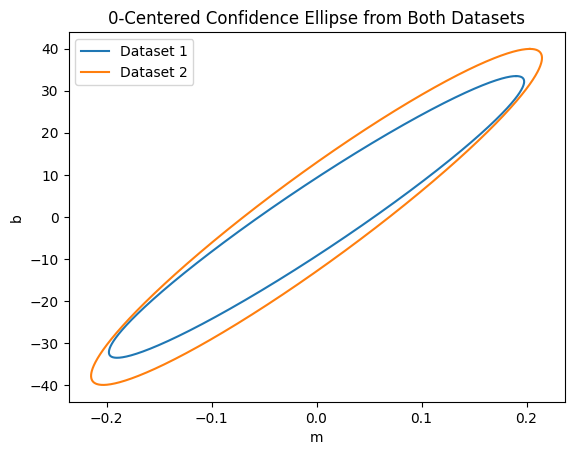

In [7]:
_= plt.plot(epoints1[0], epoints1[1], label="Dataset 1")
_= plt.plot(epoints2[0], epoints2[1], label="Dataset 2")
_= plt.legend()

_= plt.title("0-Centered Confidence Ellipse from Both Datasets")
_= plt.xlabel("m")
_= plt.ylabel("b")

Comparing the confidence intervals from both datasets, it's clear that there's more covariance between parameters in the second dataset than the first. This is seen in the above plot as the dataset 1 ellipse is flatter, implying less trend in the variance observed in the slope value and the variance observed in the b value. If the ellipse became a circle, it would imply no trend

### Problem 2

In [8]:
with open(pth.join(data_path,"data.pkl"), 'rb') as f:
    data2 = pkl.load(f)

df = pd.DataFrame(data2, columns=["time","σy",*[f"data_set_{i}" for i in range(1,12)]])
d = df[['time','σy',f'data_set_11']]
d.columns = ['time', 'σy', 'data']

In [9]:
lls = []
Ts =[]
for T2 in np.linspace(1,1_024,num=2_048):
    sig2 = TwoSignal(100, T2, np.array([1,1,1,1,1]), d)
    _=sig2.set_params(sig2.analytic_params()[0])
    
    lls.append(sig2.negloglike())
    Ts.append(T2)
    del sig2
    

output = np.column_stack([np.array(lls),np.array(Ts)])
output = pd.DataFrame(output, columns=['NegLogLikes', 'Periods'])

In [10]:
ix = output.loc[lambda x: x.NegLogLikes == output.NegLogLikes.min()].index
parab_data = output.loc[np.hstack([ix-1, ix, ix+1])]
xdata, ydata = parab_data['Periods'].values, parab_data['NegLogLikes'].values

In [11]:
def para_fit(x, a, b, c):
    return a * x**2 + b*x + c       

params, _ = opt.curve_fit(para_fit,  xdata, ydata)
fit_parab = partial(para_fit, a=params[0], b=params[1], c=params[2])
min_pt = opt.minimize(fit_parab, 257).x[0]
std_err = np.sqrt(1/(2*fit_parab.keywords['a']))

/home/nicolasjudd/.local/share/virtualenvs/py_projs-Rvb-Pndl/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


The best fit value for the second period is 257.53 with a standard error of 0.21


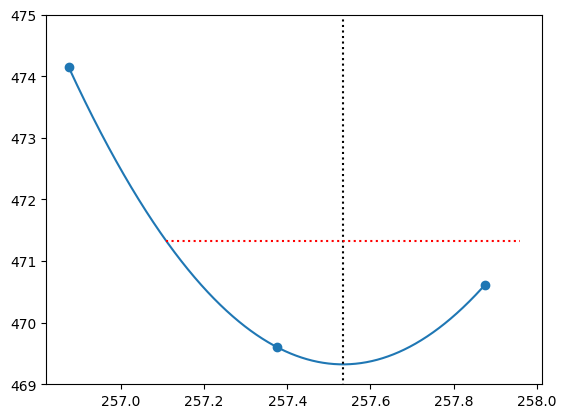

In [12]:
xs = np.linspace(xdata[0], xdata[-1], num=1_000)
ys = [fit_parab(x) for x in xs]

_ = plt.plot(xs, ys)
_ = plt.scatter(xdata, ydata)
_ = plt.vlines(min_pt,465, 475, color='k', linestyle=':')
_ = plt.hlines(fit_parab(min_pt + 2*std_err), min_pt-2*std_err, min_pt + 2*std_err, color='r', linestyle=":")
_ = plt.ylim(469, 475)

print(f"The best fit value for the second period is {min_pt:.5} with a standard error of {std_err:.2}")

From the profile likelihood, it appears that the best fit for the second period is 257.5 days with a standard uncertainty of about 0.2 days.The black dotted line above indicates the value of the period that minimizes the negative log likelihood and the red dotted line indicates the spread of the 95% confidence interval of this estimation.

### Problem 3

##### Problem 2

In [13]:
class MHMCMC:
    def __init__(self, f, q, init_x=0):
        self.f = f
        self.q = q
        self.x = init_x
        
    def sample(self, draws):
        return np.array([self.selection() for _ in range(draws)])
    
    def proposal(self):
        return self.q(self.x)
    
    def selection(self):
        q = self.proposal()
        r = np.random.uniform(0,1)

        if (self.f(q)/self.f(self.x) > r):
            self.x = q 
            
        return self.x

In [14]:
def subplot_plots(samples):   
    fig, ax = plt.subplots(2,2)
    fig.tight_layout(pad=2)
    _ = ax[0,1].axis('off')
    
    _ = ax[0,0].hist(samples.T[0], bins=1_000, density=True)
    _ = ax[1,1].hist(samples.T[1], bins=1_000, density=True)
    _ = ax[1,0].scatter(samples.T[0], samples.T[1], 
                         edgecolors='k', facecolors='none', s=40, linewidths=1)

    _ = ax[0,0].set_xlabel('x')
    _ = ax[0,0].set_ylabel('p(x)')

    _ = ax[1,1].set_xlabel('y')
    _ = ax[1,1].set_ylabel('p(y)')

    _ = ax[1,0].set_xlabel('x')
    _ = ax[1,0].set_ylabel('y')


In [15]:
real_dist = norm(2,np.sqrt(2))
prbm2_q = lambda x: norm.rvs(loc=x, scale=1)

MC = MHMCMC(real_dist.pdf, prbm2_q, init_x=0)

In [16]:
K = 100_000
samples = MC.sample(K)

Sampler found the below distribution with estimated mean of  1.96 and variance 1.99


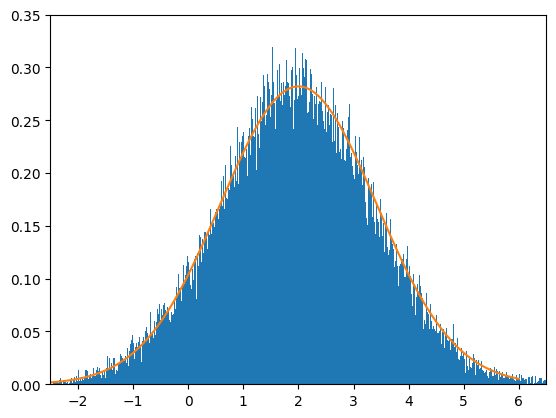

In [17]:
xs = np.linspace(-2.5, 6, num=1_000)

_ = plt.hist(samples, bins=1_000, density=True)
_ = plt.plot(xs, real_dist.pdf(xs))
_ = plt.ylim(0, 0.35)
_ = plt.xlim(-2.5, 6.5)

μ = np.mean(samples)
σ = np.std(samples)

print(f"Sampler found the below distribution with estimated mean of {μ: 0.3} and variance {σ**2:0.3}")

##### Question 4

In [18]:
prbm4_dists = {
    "Gaussian": multivariate_normal(cov=[[2.0, 1.2],[1.2, 2.0]]).pdf
   ,"Top Hat": lambda x: (3<x[0]<7)*(1<x[1]<9)
}

prbm4_q = partial(multivariate_normal.rvs, cov=np.eye(2))

gauss_mcmc = MHMCMC(prbm4_dists["Gaussian"], prbm4_q, init_x=[0,0])
tophat_mcmc = MHMCMC(prbm4_dists['Top Hat'], prbm4_q, init_x=[5,5])

In [19]:
K = 50_000
gauss_samples = gauss_mcmc.sample(K)

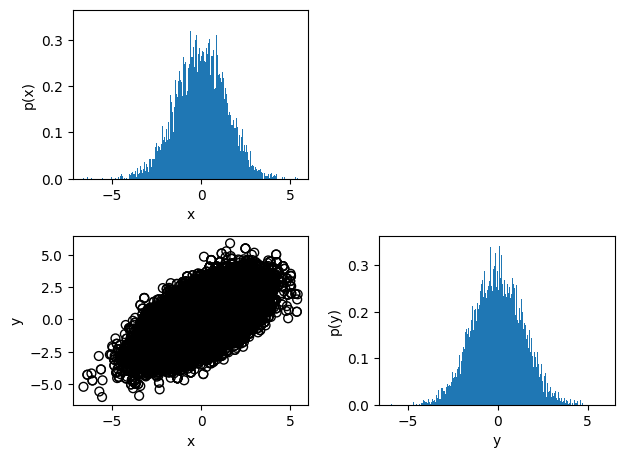

In [20]:
subplot_plots(gauss_samples)

In [21]:
K = 50_000
tophat_samples = tophat_mcmc.sample(K)

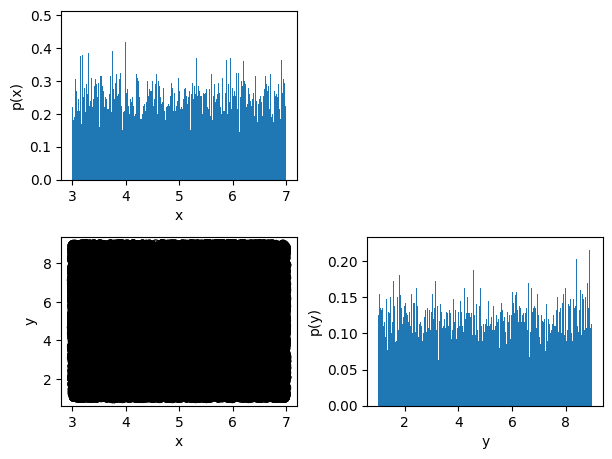

In [22]:
subplot_plots(tophat_samples)

##### Question 10

In [23]:
real_dist_10 = norm(2, np.sqrt(2))
MC10 = MHMCMC(real_dist_10.pdf, prbm2_q, init_x=0)

In [24]:
K = 10_000
samples_10 = MC10.sample(K)

In [25]:
splits = np.split(samples_10, 4)

Section 0 has mean 1.9993201267039913 and variance 1.7451285903976788
Section 1 has mean 1.9957726930203927 and variance 2.104619927275309
Section 2 has mean 2.103699223242319 and variance 2.04450414522337
Section 3 has mean 2.0438977278666304 and variance 2.0095888890408107


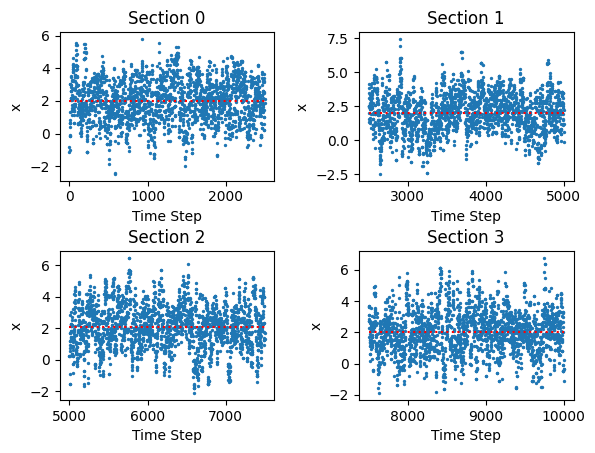

In [26]:
fig, ax = plt.subplots(2,2)
fig.tight_layout(pad=3)
for i, a in enumerate(ax.flat):
    mean = np.mean(splits[i])
    stddev = np.std(splits[i])
    _ = a.set_title(f"Section {i}")
    _ = a.set_xlabel("Time Step")
    _ = a.set_ylabel("x")
    
    _ = a.hlines(mean, i*2_500, (i+1)*2_500, color='r', linestyle=":")
    _ = a.scatter(np.array(range(2_500)) + i*2_500, splits[i], s=2)
    
    sec_str = f"Section {i} has mean {mean} and variance {stddev **2}"
    print(sec_str)

Judging by the means and variances from each section, the MCMC converges fairly quickly and is reasonably stable around the mean. The variances are a bit more turbulent, but not by much